# <center><u><h1 style="font-family: 'Your Font', sans-serif; font-size: 32px; font-weight: bold; color: black;">Project Report</h1></u></center>
## <center>Comparative Analysis of Registered Trees in Cologne and Frankfurt (Year 2020)</center>
### Summary and Rationale
The project aims to conduct a comparative analysis of the number of registered trees in Cologne and Frankfurt for the year 2020. Understanding the differences and
similarities in tree populations between these two cities can provide valuable insights into urban forestry and environmental management. This analysis will
utilize data from two distinct datasets, one for Cologne and another for Frankfurt.

The project will employ data science methodologies and statistical techniques to explore and visualize the tree data. By examining factors such as tree species
distribution, Age distribution, Trunk diameter distribution, Height distribution, and geographic distribution, the project aims to answer the main question regarding the comparative tree populations.

### Main Questions
1. What is the distribution of age of trees in the region of Colonge and Frankfurt for the year 2020?
2. What is the distribution of height of trees in the region of Colonge and Frankfurt for the year 2020?
3. What is the distribution of trunk diameter of trees in the region of Colonge and Frankfurt for the year 2020?
4. Analyses of type of trees in the region of Cologne and Frankfurt for the year 2020.
5. Geographical visualization of Registers tree in both regions for the year 2020?
6. What the density of trees per square km in both the region?

### Datasources
#### Datasource1: Cologne tree register
* Metadata URL: https://offenedaten-koeln.de/dataset
* Data URL: https://offenedaten-koeln.de/sites/default/files/Bestand_Einzelbaeume_Koeln_0.csv
* Data Type: CSV

The Cologne Tree Register dataset provides comprehensive information on the tree population within the city of Cologne, Germany. It includes data on tree species,
location, and other attributes, offering insights into urban forestry and environmental management in the region.

#### Datasource1: Tree register Frankfurt am Main (2020)
* Metadata URL: https://www.offenedaten.frankfurt.de/dataset
* Data URL: https://offenedaten.frankfurt.de/dataset/73c5a6b3-c033-4dad-bb7d-8783427dd233/resource/e53aacb4-4462-4b69-ab9f-4252a402a082/download/baumauswahl_veroffentlichung_8-berbeitetrkr.csv
* Data Type: CSV

The "Tree Register Frankfurt am Main (2020)" dataset provides comprehensive information on the city's tree inventory for the year 2020, offering details on tree species, location, and more. This dataset is a valuable resource for environmental analysis and urban forestry research.

## Used dependencies
Importing necessary libraries that will be used in the task

In [88]:
# import necessary libraries
import pandas as pd
from sqlalchemy import create_engine
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
import datetime
import folium
from folium.plugins import MarkerCluster
from IPython.display import Image, display, HTML

%matplotlib inline

# Project Flow

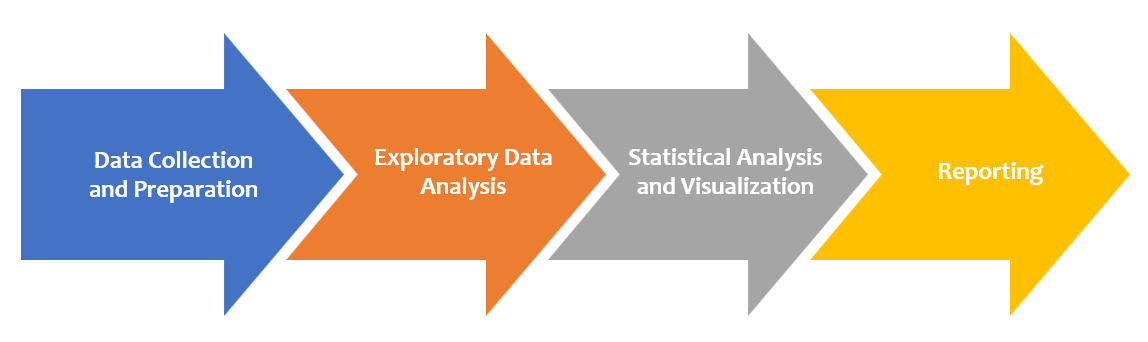

In [89]:
image_path = 'output_data/projectflow.png'
display(Image(filename=image_path))

### 1. Data Collection and Preparation
Set up a mechanism to fetch the data of trees from the data source and pass it through the ETL (Extract, Transform, Load) pipeline to create an Sqlite database.

##### To extract the data from csv file
```python
def Extract(file):
    df = pd.read_csv(file, delimiter=";")
    return df
```
##### To transform the data (change column labels)
```python
def Transform(df, column_map, col_to_drop):
    df = df.drop(columns = col_to_drop)
    df = df.rename(columns=column_map)
    return df
```
##### Load data to create a SQLite file
```python
def Load(df, table):
    engine = create_engine(f"sqlite:///../data/Tree.sqlite")
    df.to_sql(table, engine, if_exists="replace")
```
##### Main function
```python
def main():
    file1 = "https://offenedaten-koeln.de/sites/default/files/Bestand_Einzelbaeume_Koeln_0.csv"
    file2 = "https://offenedaten.frankfurt.de/dataset/73c5a6b3-c033-4dad-bb7d-8783427dd233/resource/e53aacb4-4462-4b69-ab9f-4252a402a082/download/baumauswahl_veroffentlichung_8-berbeitetrkr.csv"

    df1 = Extract(file1)
    col_to_drop1 = ["Baum-Nr.","HausNr","Lage","Art","Sorte","DeutscherN"]
    column_map1 = {
        "PFLEGEOBJE" : "Care_Object",
        "Objekttyp" : "Object_Type",
        "Bezirk" : "District",
        "X_Koordina" : "x_coordinate",
        "Y_Koordina" : "y_coordinate",
        "STAMMVON" : "Tribe_of",
        "STAMMBIS" : "trunk diameter",
        "KRONE" : "Crown",
        "HöHE" : "Height",
        "AlterSchätzung" : "Age",
        "Gattung" : "Genus"
    }

    df1 = Transform(df1, column_map1, col_to_drop1)
    Load(df1, "table_1")

    df2 = Extract(file2)
    col_to_drop2 = ["STANDORT","BAUM_STATU","GATTUNGART","GA_LANG","GEBIET","STRASSE"]
    column_map2 = {
        "BAUMNUMMER" : "Tree_number",
        "HOCHWERT" : "y_coordinate",
        "RECHTSWERT" : "x_coordinate",
        "GATTUNGART" : "Genus_type",
        "GATTUNG" : "Genus",
        "GA_LANG" : "GA_LANG",
        "KR_DURCHM" : "trunk diameter",
        "ST_UMFANG" : "ST_Scope",
        "GEBIET" : "Area",
        "STRASSE" : "Street",
        "BAUMHOEHE" : "Height",
        "ST_DURCHM" : "St_diam",
        "PFLANZJAHR" : "Planting_year",
        "Kr_Radius" : "trunk radius",
    }

    df2 = Transform(df2, column_map2, col_to_drop2)
    Load(df2, "table_2")
```  
#### Run the main function
```python
main()
```

### 2. Exploratory Data Analysis (EDA)
- Conduct exploratory data analysis on the datasets of Cologne and Frankfurt.
- Identify statistical patterns and distributions in datasets.

### Load data
Create a pandas dataframe using the local sqlite file.

In [90]:
# To connect to the database
def connect_to_database(database_path):
    
    # Connect to the SQLite database and retrieve table names.
    conn = sqlite3.connect(database_path)
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    table_names = [table[0] for table in cursor.fetchall()]
    return conn, table_names

# Read tables from the dataframe
def read_tables_into_dataframes(conn, table_names):
    
    # Read tables into Pandas DataFrames and store them in a dictionary.
    dataframes = {}
    for table_name in table_names:
        query = f"SELECT * FROM {table_name};"
        df = pd.read_sql_query(query, conn)
        dataframes[table_name] = df
    return dataframes

# print first 5 rows of the data
def perform_data_analysis(dataframes):

    # Perform basic data analysis on each DataFrame.
    for table_name, df in dataframes.items():
        print(f"Table: {table_name}")
        print(df.head())
        print('\n')
    
# Close the database
def close_database_connection(conn):
    """
    Close the database connection.
    """
    conn.close()

In [91]:
# Connect to the SQLite database
database_path = r'..\data\Tree.sqlite'
conn, table_names = connect_to_database(database_path)

In [92]:
# Read the tables into Pandas DataFrames
dataframes = read_tables_into_dataframes(conn, table_names)

### Bird Eye view of the dataset
Understand the features and attributes inside the datasets

In [93]:
# Perform data analysis
perform_data_analysis(dataframes)

# Close the database connection
close_database_connection(conn)

Table: table_1
   index  Care_Object  Object_Type  District  x_coordinate  y_coordinate  \
0      0          461            6         8        359814       5645658   
1      1         1637            6         8        359797       5645630   
2      2         1207            6         9        358277       5651918   
3      3         1207            6         9        358271       5651922   
4      4         1207            6         9        358240       5652009   

   Tribe_of  trunk diameter  Crown  Height  Age     Genus  
0         0              50      8      10   25   Robinia  
1         0              45     10      10   25   Robinia  
2         0              70     12      16   55  Platanus  
3         0              60     10      16   45  Platanus  
4         0               5      1       6    0    Sorbus  


Table: table_2
   index Tree_number y_coordinate x_coordinate     Genus trunk diameter  \
0      0           1    5549510,9   473366,239  Platanus              8   
1

In [94]:
df1 = dataframes['table_1']
df2 = dataframes['table_2']

In [95]:
# Print Info of cologne dataset
print(df1.info())
print("\n\n",df1.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134189 entries, 0 to 134188
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   index           134189 non-null  int64 
 1   Care_Object     134189 non-null  int64 
 2   Object_Type     134189 non-null  int64 
 3   District        134189 non-null  int64 
 4   x_coordinate    134189 non-null  int64 
 5   y_coordinate    134189 non-null  int64 
 6   Tribe_of        134189 non-null  int64 
 7   trunk diameter  134189 non-null  int64 
 8   Crown           134189 non-null  int64 
 9   Height          134189 non-null  int64 
 10  Age             134189 non-null  int64 
 11  Genus           82809 non-null   object
dtypes: int64(11), object(1)
memory usage: 12.3+ MB
None


 index                 0
Care_Object           0
Object_Type           0
District              0
x_coordinate          0
y_coordinate          0
Tribe_of              0
trunk diameter        0
Crown  

In [96]:
# Print Info of frankfurt dataset
print(df2.info())
print("\n\n",df2.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158529 entries, 0 to 158528
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   index           158529 non-null  int64 
 1   Tree_number     158529 non-null  object
 2   y_coordinate    158529 non-null  object
 3   x_coordinate    158529 non-null  object
 4   Genus           158529 non-null  object
 5   trunk diameter  158529 non-null  object
 6   ST_Scope        158529 non-null  int64 
 7   Height          158529 non-null  int64 
 8   St_diam         158529 non-null  int64 
 9   Planting_year   158529 non-null  int64 
 10  trunk radius    158529 non-null  object
dtypes: int64(5), object(6)
memory usage: 13.3+ MB
None


 index             0
Tree_number       0
y_coordinate      0
x_coordinate      0
Genus             0
trunk diameter    0
ST_Scope          0
Height            0
St_diam           0
Planting_year     0
trunk radius      0
dtype: int64


### Convert the data type of some relevent features
For some features correct the represention of the numeric data and convert the data type for further analysis

In [97]:
# Data preprocessing
# convert x_coordinate value to float
df2["x_coordinate"] = df2["x_coordinate"].replace(',', '.', regex=True)
df2["x_coordinate"] = pd.to_numeric(df2["x_coordinate"], errors='coerce').astype(float)

# convert y_coordinate value to float
df2["y_coordinate"] = df2["y_coordinate"].replace(',', '.', regex=True)
df2["y_coordinate"] = pd.to_numeric(df2["y_coordinate"], errors='coerce').astype(float)

# convert trunck diameter value to float
df2["trunk diameter"] = df2["trunk diameter"].replace(',', '.', regex=True)
df2["trunk diameter"] = pd.to_numeric(df2["trunk diameter"], errors='coerce').astype(float)

In [98]:
# Print Info of frankfurt dataset
print(df2.info())
print("\n\n",df2.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158529 entries, 0 to 158528
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   index           158529 non-null  int64  
 1   Tree_number     158529 non-null  object 
 2   y_coordinate    158529 non-null  float64
 3   x_coordinate    158529 non-null  float64
 4   Genus           158529 non-null  object 
 5   trunk diameter  158529 non-null  float64
 6   ST_Scope        158529 non-null  int64  
 7   Height          158529 non-null  int64  
 8   St_diam         158529 non-null  int64  
 9   Planting_year   158529 non-null  int64  
 10  trunk radius    158529 non-null  object 
dtypes: float64(3), int64(5), object(3)
memory usage: 13.3+ MB
None


 index             0
Tree_number       0
y_coordinate      0
x_coordinate      0
Genus             0
trunk diameter    0
ST_Scope          0
Height            0
St_diam           0
Planting_year     0
trunk radius      0


### Analyze the centers and dispersions of the datasets
Overview the datasets based on the center and spread of the distributions of each feature

In [99]:
# Describe the cologne dataset
df1.describe()

index    Care_Object    Object_Type       District  \
count  134189.000000  134189.000000  134189.000000  134189.000000   
mean    67094.000000    2886.313297       3.934309       2.899351   
std     38737.171973    4217.507972       3.064975       2.854197   
min         0.000000       0.000000       0.000000       0.000000   
25%     33547.000000       0.000000       0.000000       0.000000   
50%     67094.000000     876.000000       6.000000       3.000000   
75%    100641.000000    7843.000000       6.000000       5.000000   
max    134188.000000  271541.000000      11.000000       9.000000   

        x_coordinate  y_coordinate       Tribe_of  trunk diameter  \
count  134189.000000  1.341890e+05  134189.000000   134189.000000   
mean   308681.650411  4.997295e+06       0.212290       22.391552   
std    121223.595346  1.800581e+06       2.374227       28.347221   
min         0.000000  0.000000e+00       0.000000      -40.000000   
25%    351758.000000  5.641834e+06       0.000000        0.000000   
50%    354819.000000  5.645139e+06       0.000000       15.000000   
75%    358260.000000  5.648161e+06       0.000000       35.000000   
max    368958.000000  5.659832e+06      89.000000     3035.000000   

               Crown         Height            Age  
count  134189.000000  134189.000000  134189.000000  
mean        3.901914       7.031985      14.807682  
std         5.038550      12.710500      21.023529  
min        -8.000000      -8.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         3.000000       6.000000       0.000000  
75%         7.000000      12.000000      30.000000  
max       810.000000    3515.000000     195.000000

In [100]:
# Describe the frankfurt dataset
df2.describe()

index  y_coordinate   x_coordinate  trunk diameter  \
count  158529.00000  1.585290e+05  158529.000000   158529.000000   
mean    79264.00000  5.552855e+06  475352.562936        7.045351   
std     45763.52475  3.396903e+03    4199.308748        4.076435   
min         0.00000  5.545113e+06  463162.720000        2.000000   
25%     39632.00000  5.550333e+06  472849.099000        4.000000   
50%     79264.00000  5.552645e+06  475554.289000        6.000000   
75%    118896.00000  5.554893e+06  478174.000000        9.000000   
max    158528.00000  5.563900e+06  485429.876900       43.000000   

            ST_Scope         Height        St_diam  Planting_year  
count  158529.000000  158529.000000  158529.000000   158529.00000  
mean      105.971759      12.746229      33.762069     1979.17318  
std        73.438647       6.181827      23.378766       25.41263  
min         0.000000       0.000000       0.000000     1653.00000  
25%        53.000000       8.000000      17.000000     1968.00000  
50%        88.000000      12.000000      28.000000     1982.00000  
75%       141.000000      17.000000      45.000000     1996.00000  
max      2082.000000      72.000000     663.000000     2073.00000

### 3. Statistical Analysis and Visualizations
Conduct statistical analysis to find the answers to the main questions for this project.
### Question 1. What is the distribution of age of trees in the region of Colonge and Frankfurt for the year 2020?
First calculate the age of tree from planting year and create a new feature

In [101]:
# Feature processing
# Retrieve age of the tree from planting year from the Frankfurt dataset
# Get Current year
current_year = datetime.datetime.now().year

# Calculate age from planting year
df2['Age'] = current_year - df2['Planting_year']

### Visualize the distribution of Age by a box plot

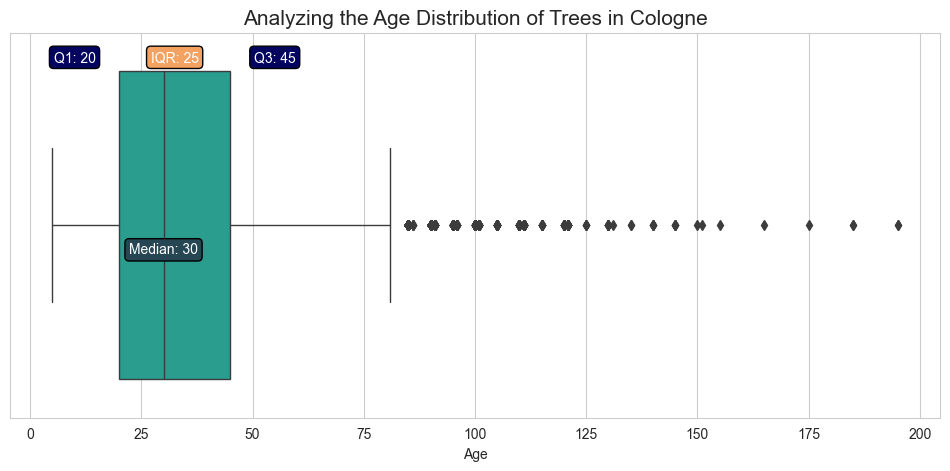

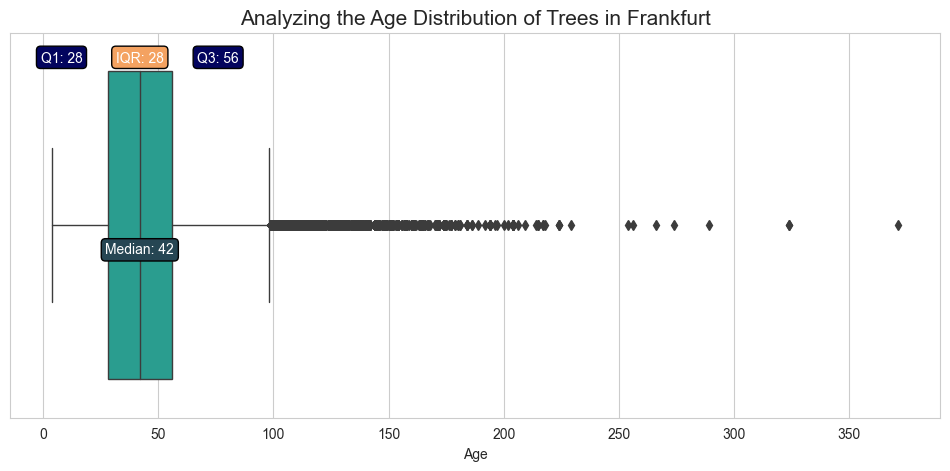

In [102]:
# Create a box plot for the distribution of ages of trees in cologne
plt.figure(figsize=(12, 5))

# Create a box plot for the 'Age' column
ax = sns.boxplot(x='Age', data=df1[df1['Age'] != 0], color="#2a9d8f", linewidth=1, saturation= 1)

# Annotate the plot with statistical information for 'Age' column
median_value_age_estimate = df1['Age'][df1['Age'] != 0].median()
q1_value_age_estimate = df1['Age'][df1['Age'] != 0].quantile(0.25)
q3_value_age_estimate = df1['Age'][df1['Age'] != 0].quantile(0.75)
iqr_value_age_estimate = q3_value_age_estimate - q1_value_age_estimate

ax.annotate(f'Median: {median_value_age_estimate:.0f}', xy=(median_value_age_estimate, 0.1),
            xytext=(0, 10), textcoords='offset points', ha='center', va='center', color='white',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='#264653'))

ax.annotate(f'Q1: {q1_value_age_estimate:.0f}', xy=(q1_value_age_estimate - 10, -0.4),
            xytext=(0, 10), textcoords='offset points', ha='center', va='center', color='white',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='#03045e'))

ax.annotate(f'Q3: {q3_value_age_estimate:.0f}', xy=(q3_value_age_estimate + 10, -0.4),
            xytext=(0, 10), textcoords='offset points', ha='center', va='center', color='white',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='#03045e'))

ax.annotate(f'IQR: {iqr_value_age_estimate:.0f}', xy=((q1_value_age_estimate + q3_value_age_estimate) / 2, -0.4),
            xytext=(0, 10), textcoords='offset points', ha='center', va='center', color='white',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='#f4a261'))

# Set the title for the first subplot
plt.title('Analyzing the Age Distribution of Trees in Cologne', fontsize=15)


# Create a box plot for the distribution of ages of trees in frankfurt
plt.figure(figsize=(12, 5))

# Create a box plot for the 'Age' column
ax = sns.boxplot(x='Age', data=df2[df2["Age"] > 0], color="#2a9d8f", linewidth=1, saturation= 1)

# Annotate the plot with statistical information for 'Age' column
median_value_age = df2['Age'].median()
q1_value_age = df2['Age'].quantile(0.25)
q3_value_age = df2['Age'].quantile(0.75)
iqr_value_age = q3_value_age - q1_value_age

ax.annotate(f'Median: {median_value_age:.0f}', xy=(median_value_age, 0.1),
            xytext=(0, 10), textcoords='offset points', ha='center', va='center', color='white',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='#264653'))

ax.annotate(f'Q1: {q1_value_age:.0f}', xy=(q1_value_age - 20, -0.4),
            xytext=(0, 10), textcoords='offset points', ha='center', va='center', color='white',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='#03045e'))

ax.annotate(f'Q3: {q3_value_age:.0f}', xy=(q3_value_age + 20, -0.4),
            xytext=(0, 10), textcoords='offset points', ha='center', va='center', color='white',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='#03045e'))

ax.annotate(f'IQR: {iqr_value_age:.0f}', xy=((q1_value_age + q3_value_age) / 2, -0.4),
            xytext=(0, 10), textcoords='offset points', ha='center', va='center', color='white',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='#f4a261'))

# Set the title for the second subplot
plt.title('Analyzing the Age Distribution of Trees in Frankfurt',fontsize=15)

# Show the subplots
plt.show()


### Insights
The box plots comparing the age distribution of trees in Cologne and Frankfurt reveal distinct patterns. Cologne exhibits a median age of 30 with an interquartile range (IQR) of 25, featuring a notable outlier of approximately 200 years, showcasing a diverse age spectrum. In contrast, Frankfurt displays a higher median age of 41, accompanied by an IQR of 28. Notably, Frankfurt's data includes a remarkable outlier of around 370 years, suggesting the presence of exceptionally aged trees. Further it can also be depicted from the IQRs of the above visualizations that most of the trees in these regions are planted within 25-28 years before 2020 which is a postive sign for a better environment. 

This analysis underscores the intriguing variations in the age demographics of urban trees between the two cities, providing valuable insights into their respective urban forestry landscapes.

### Question 2. What is the distribution of height of trees in the region of Colonge and Frankfurt for the year 2020?
### Visualize the distribution of Height (meters) by a Violin plot

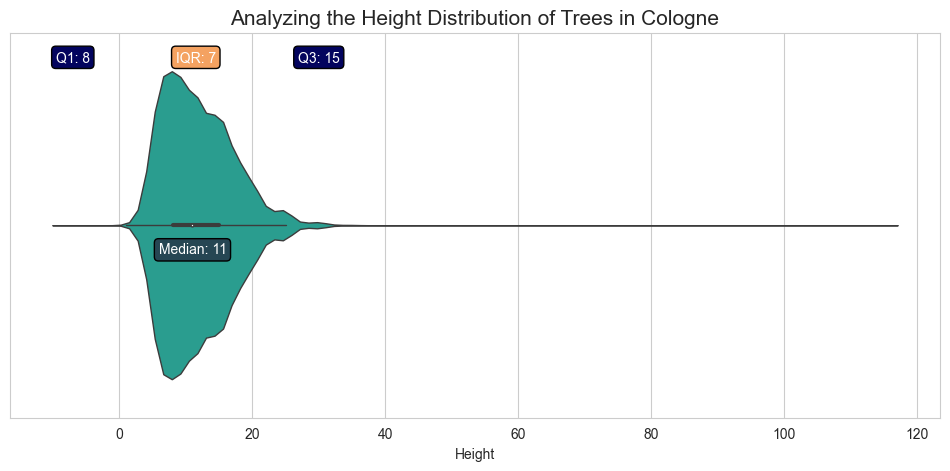

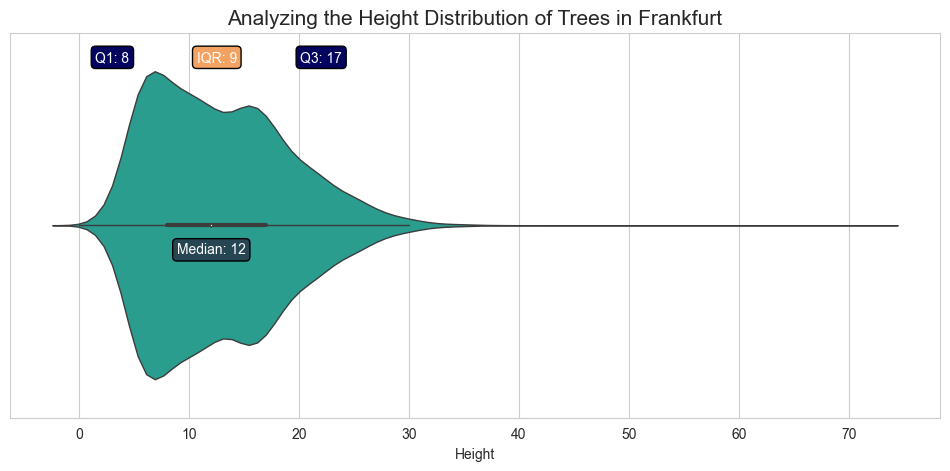

In [103]:
# Create a violin plot for the 'Height' column in cologne dataset
plt.figure(figsize=(12, 5))
# Restricting the height of the trees as the record highest tree is 115 meters (this removes the data errors)
ax = sns.violinplot(x='Height', data=df1[(df1["Height"] != 0) & (df1["Height"] <= 115)], color="#2a9d8f", linewidth=1, saturation = 1, bw = 0.2)

# Annotate the plot with statistical information
median_value = df1['Height'][(df1["Height"] != 0) & (df1["Height"] < 500)].median()
q1_value = df1['Height'][(df1["Height"] != 0) & (df1["Height"] < 500)].quantile(0.25)
q3_value = df1['Height'][(df1["Height"] != 0) & (df1["Height"] < 500)].quantile(0.75)
iqr_value = q3_value - q1_value

ax.annotate(f'Median: {median_value:.0f}', xy=(median_value, 0.1),
            xytext=(0, 10), textcoords='offset points', ha='center', va='center', color='white',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='#264653'))

ax.annotate(f'Q1: {q1_value:.0f}', xy=(q1_value - 15, -0.4),
            xytext=(0, 10), textcoords='offset points', ha='center', va='center', color='white',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='#03045e'))

ax.annotate(f'Q3: {q3_value:.0f}', xy=(q3_value + 15, -0.4),
            xytext=(0, 10), textcoords='offset points', ha='center', va='center', color='white',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='#03045e'))

ax.annotate(f'IQR: {iqr_value:.0f}', xy=((q1_value + q3_value) / 2, -0.4),
            xytext=(0, 10), textcoords='offset points', ha='center', va='center', color='white',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='#f4a261'))

# Set the title
plt.title('Analyzing the Height Distribution of Trees in Cologne',fontsize=15)



# Create a violin plot for the 'Height' column in frankfurt dataset
plt.figure(figsize=(12, 5))

ax = sns.violinplot(x='Height', data=df2, color="#2a9d8f", linewidth=1, saturation = 1, bw = 0.2)

# Annotate the plot with statistical information
median_value = df2['Height'].median()
q1_value = df2['Height'].quantile(0.25)
q3_value = df2['Height'].quantile(0.75)
iqr_value = q3_value - q1_value

ax.annotate(f'Median: {median_value:.0f}', xy=(median_value, 0.1),
            xytext=(0, 10), textcoords='offset points', ha='center', va='center', color='white',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='#264653'))

ax.annotate(f'Q1: {q1_value:.0f}', xy=(q1_value - 5, -0.4),
            xytext=(0, 10), textcoords='offset points', ha='center', va='center', color='white',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='#03045e'))

ax.annotate(f'Q3: {q3_value:.0f}', xy=(q3_value + 5, -0.4),
            xytext=(0, 10), textcoords='offset points', ha='center', va='center', color='white',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='#03045e'))

ax.annotate(f'IQR: {iqr_value:.0f}', xy=((q1_value + q3_value) / 2, -0.4),
            xytext=(0, 10), textcoords='offset points', ha='center', va='center', color='white',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='#f4a261'))

# Set the title
plt.title('Analyzing the Height Distribution of Trees in Frankfurt',fontsize=15)

# Show the plot
plt.show()


### Insights
The violin plots contrasting the height distribution of trees in Cologne and Frankfurt unveil noteworthy insights. Cologne showcases a median height of 11 meters, characterized by a relatively tight interquartile range (IQR) of 7 meters, suggesting uniformity in tree heights. In Frankfurt, the median height rises to 12 meters, accompanied by a wider IQR of 9 meters, indicating greater variability in tree heights. This comparative analysis illuminates the distinct patterns in the vertical dimensions of urban trees between the two cities, shedding light on potential factors influencing their growth and development.

### Question 3. What is the distribution of trunk diameter of trees in the region of Colonge and Frankfurt for the year 2020?
### Visualize the distribution of Trunk Diameter (cm) by a Bar graph

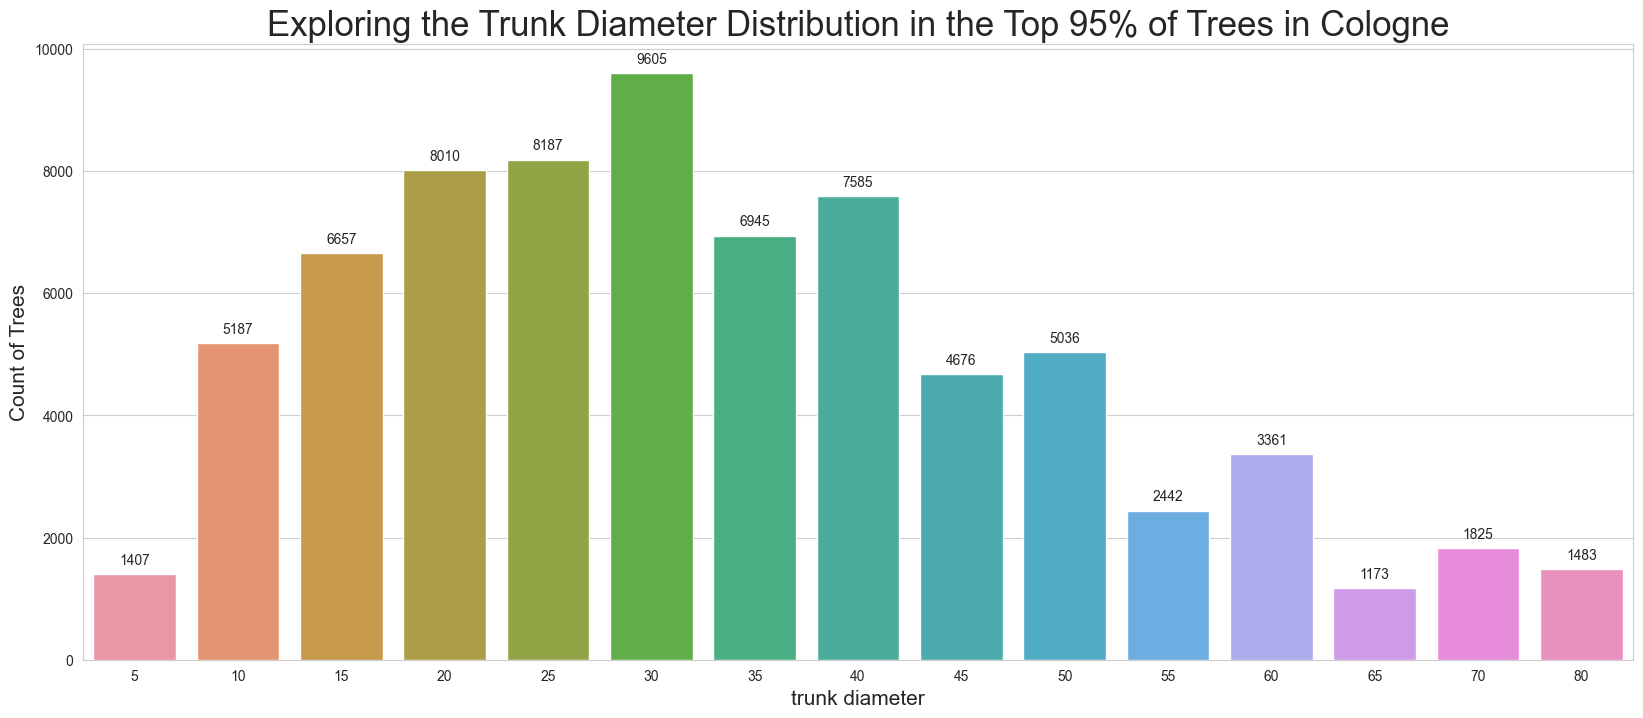

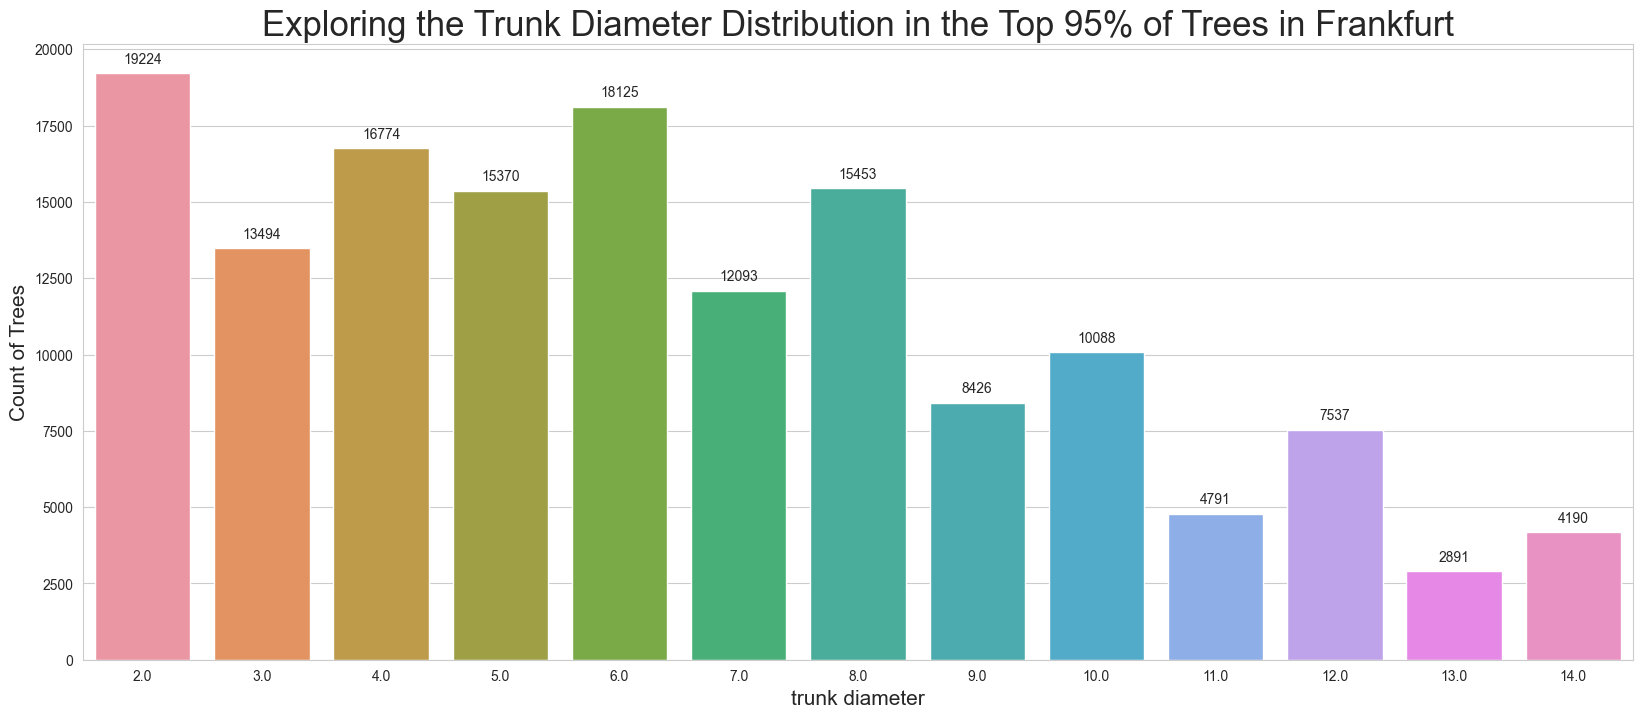

In [104]:
# Create a bar graph for the distribution of trunk diameters in Cologne
plt.figure(figsize=(20, 8))

sns.set_palette("deep")
sns.set_style("whitegrid")

# Calculate the top 95% of values
top_95_percent_values = df1['trunk diameter'].value_counts(normalize=True).cumsum().lt(0.95)

# Filter the DataFrame based on the top 95% values
filtered_df = df1[df1['trunk diameter'].isin(top_95_percent_values[top_95_percent_values].index) &  (df1['trunk diameter'] != 0)]

# Create a count plot
ax = sns.countplot(x='trunk diameter', data=filtered_df)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Exploring the Trunk Diameter Distribution in the Top 95% of Trees in Cologne', fontsize=25)
plt.xlabel('trunk diameter', fontsize = 15)
plt.ylabel('Count of Trees', fontsize = 15)

# Create a bar graph for the distribution of trunk diameters in Frankfurt
plt.figure(figsize=(20, 8))

sns.set_palette("deep")
sns.set_style("whitegrid")

# Calculate the top 95% of values
top_95_percent_values = df2['trunk diameter'].value_counts(normalize=True).cumsum().lt(0.95)

# Filter the DataFrame based on the top 95% values
filtered_df = df2[df2['trunk diameter'].isin(top_95_percent_values[top_95_percent_values].index) &  (df2['trunk diameter'] != 0)]

# Create a count plot
ax = sns.countplot(x='trunk diameter', data=filtered_df)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Exploring the Trunk Diameter Distribution in the Top 95% of Trees in Frankfurt', fontsize=25)
plt.xlabel('trunk diameter', fontsize = 15)
plt.ylabel('Count of Trees', fontsize = 15)


plt.show()

### Insights
The bar graphs illustrating the trunk diameter distribution of trees reveal distinct patterns for Cologne and Frankfurt. In Cologne, the distribution appears nearly normal, centered around 30 cm. This suggests that a significant proportion of trees in Cologne exhibit a diameter of approximately 30 cm. With 95% of trees falling within the 5-80 cm range, there is notable diversity, particularly with a prevalence of thicker trees.

Conversely, Frankfurt's trunk diameter distribution exhibits a right-skewed pattern, indicating a concentration of trees with diameters around 2 cm. The data further reveals that 95% of trees in Frankfurt fall within the 2-14 cm range, reflecting a prevalence of thinner trees in comparison to Cologne. These observations provide valuable insights into the differing characteristics of tree populations in the two regions.

### Question 4. Analyses of type of trees in the region of Cologne and Frankfurt for the year 2020.
### Visualize the Genus of trees in both regions by a Pareto Chart

C:\Users\HP\AppData\Local\Temp\ipykernel_8196\475403242.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
C:\Users\HP\AppData\Local\Temp\ipykernel_8196\475403242.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)


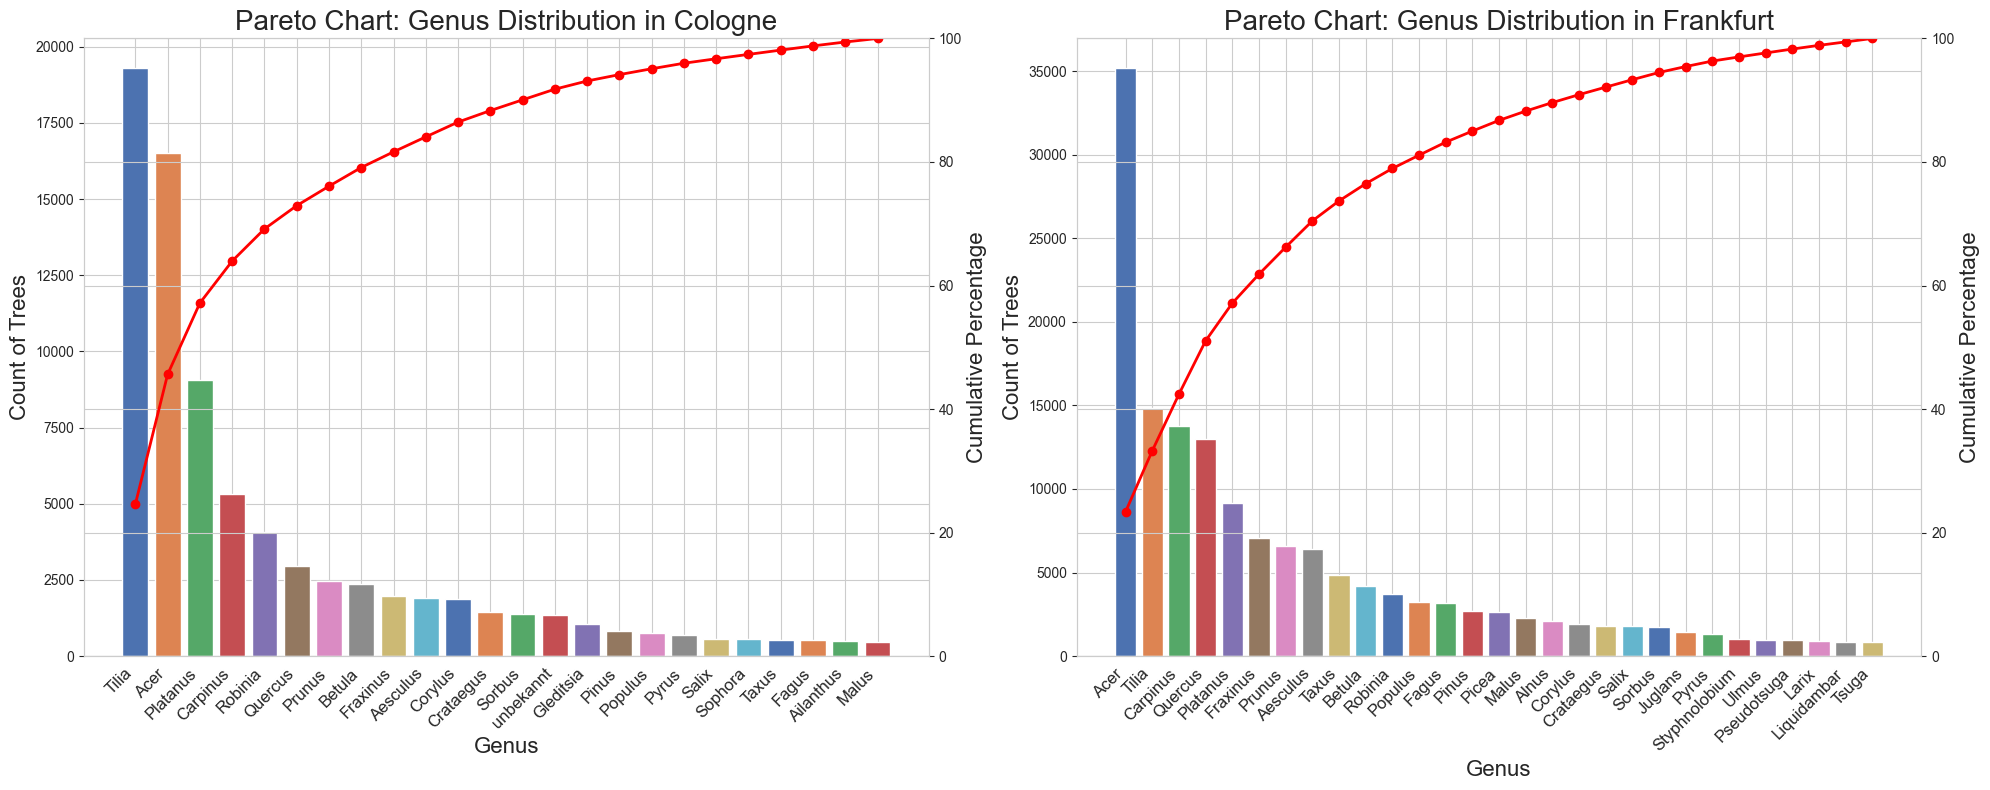

In [105]:
# Function to create a Pareto chart
def create_pareto_chart(ax, df, title):
    # Calculate the top 95% of values
    top_95_percent_values = df['Genus'].value_counts(normalize=True).cumsum().lt(0.95)

    # Filter the DataFrame based on the top 95% values
    filtered_df = df[df['Genus'].isin(top_95_percent_values[top_95_percent_values].index) & (df['Genus'] != 0)]

    # Count the occurrences of each genus
    genus_counts = filtered_df['Genus'].value_counts()

    # Calculate cumulative percentages
    cumulative_percentage = genus_counts.cumsum() / genus_counts.sum() * 100

    # Sort values in descending order
    sorted_genus_counts = genus_counts.sort_values(ascending=False)
    sorted_cumulative_percentage = sorted_genus_counts.cumsum() / sorted_genus_counts.sum() * 100

    # Create Pareto chart
    ax.bar(sorted_genus_counts.index, sorted_genus_counts, color=sns.color_palette("deep"))
    ax2 = ax.twinx()
    ax2.plot(sorted_genus_counts.index, sorted_cumulative_percentage, color='red', marker='o', linestyle='-', linewidth=2)
    ax2.set_ylim([0, 100])

    # Set the title and labels
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Genus', fontsize=16)
    ax.set_ylabel('Count of Trees', fontsize=16)
    ax2.set_ylabel('Cumulative Percentage', fontsize=16)

    # Rotate x-axis labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Create Pareto chart for tree genus in the region of Cologne
create_pareto_chart(axes[0], df1, 'Pareto Chart: Genus Distribution in Cologne')

# Create Pareto chart for tree genus in the region of Frankfurt
create_pareto_chart(axes[1], df2, 'Pareto Chart: Genus Distribution in Frankfurt')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


### Insights
Analyzing the Pareto charts of tree genus types in Cologne and Frankfurt provides insights into the environmental characteristics of the two regions. In Cologne, the dominant tree genera, including Tilia, Acer, Platanus, Carpinus, Robinia, Quercus, Prunus, and Betula, make up the top 80%. This composition suggests a diverse and well-balanced urban environment with a mix of deciduous and coniferous trees, contributing to a varied and aesthetically pleasing cityscape.

On the other hand, Frankfurt's predominant tree genera, such as Acer, Tilia, Carpinus, Quercus, Platanus, Fraxinus, Prunus, Aesculus, Taxus, Betula, and Robinia, form the top 80%. The presence of a diverse set of genera, including deciduous and evergreen varieties, indicates a rich and well-maintained urban greenery in Frankfurt.

Overall, both cities exhibit a commitment to biodiversity and urban forestry, as reflected in the variety of tree genera present in their respective environments. The specific composition of tree types contributes to the overall character and aesthetic appeal of each region, showcasing a thoughtful approach to urban planning and environmental sustainability.

### Question 5. Geographical visualization of Registers tree in both regions for the year 2020?
### Visualize of Geographical locations of the Registered Trees in both regions
Extract the coordinates of latitudes and longitudes of the registered trees from the x and y coordinates of the given dataset

In [106]:
# Preprocess the data to get map coordinates
from pyproj import Proj, transform

# UTM (Universal Transverse Mercator) Zone for Germany
utm_zone = 32

# Define the source and target projections
source_proj = Proj(proj='utm', zone=utm_zone, ellps='WGS84')
target_proj = Proj(proj='latlong', datum='WGS84')

# Define dataset
df3 = df1[['x_coordinate','y_coordinate']][df1[['x_coordinate','y_coordinate']] != 0]
df4 = df2[['x_coordinate','y_coordinate']][df2[['x_coordinate','y_coordinate']] != 0]

# Convert the coordinates
df3['longitude'], df3['latitude'] = transform(source_proj, target_proj, df3['x_coordinate'], df3['y_coordinate'])
df4['longitude'], df4['latitude'] = transform(source_proj, target_proj, df4['x_coordinate'], df4['y_coordinate'])

C:\Users\HP\AppData\Local\Temp\ipykernel_8196\2087887903.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  df3['longitude'], df3['latitude'] = transform(source_proj, target_proj, df3['x_coordinate'], df3['y_coordinate'])
C:\Users\HP\AppData\Local\Temp\ipykernel_8196\2087887903.py:17: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  df4['longitude'], df4['latitude'] = transform(source_proj, target_proj, df4['x_coordinate'], df4['y_coordinate'])


In [107]:
# Remove Nan values from the datasets
df3 = df3.dropna()
df4 = df4.dropna()

#### Analyze the spread of latitude and longitude values (minima and maxima)

In [108]:
# Find the min and max values of latitude and longitude for Cologne
min_lat, max_lat = df3['latitude'].min(), df3['latitude'].max()
min_lon, max_lon = df3['longitude'].min(), df3['longitude'].max()
print(min_lat, max_lat)
print(min_lon, max_lon)

50.834861208396504 51.07036418712115
6.816582332079919 7.136124298540714


In [109]:
# Find the min and max values of latitude and longitude for frankfurt
min_lat, max_lat = df4['latitude'].min(), df4['latitude'].max()
min_lon, max_lon = df4['longitude'].min(), df4['longitude'].max()
print(min_lat, max_lat)
print(min_lon, max_lon)

50.0578608963786 50.22639508499143
8.484980690641425 8.796105995418031


#### Geographical visualization of Registered Trees in the region of Cologne

In [110]:
# Coordinates in a projected coordinate system
x_coordinate = df3['latitude']
y_coordinate = df3['longitude']

# Create a Folium map centered around the mean
m = folium.Map(location=[x_coordinate.mean(), y_coordinate.mean()], zoom_start=10)

# Add the Stamen Terrain tile layer for land information
folium.TileLayer('OpenStreetmap').add_to(m)

# Add a circle marker for each coordinate
for index, row in df3.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=0.1,  # Set the radius of the circle marker
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7
    ).add_to(m)

# Define the bounding box
min_lat, max_lat = 50.9, 51
min_lon, max_lon = 6.9, 7.1

# Set the visible area of the map based on the bounding box
m.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])

# Save the map as an HTML file
# m.save(r'output_data/cologne_map_with_circles_selective_area.html')

# Save the map as an image
#m.save('output_data/cologne_map.png', 'PNG')


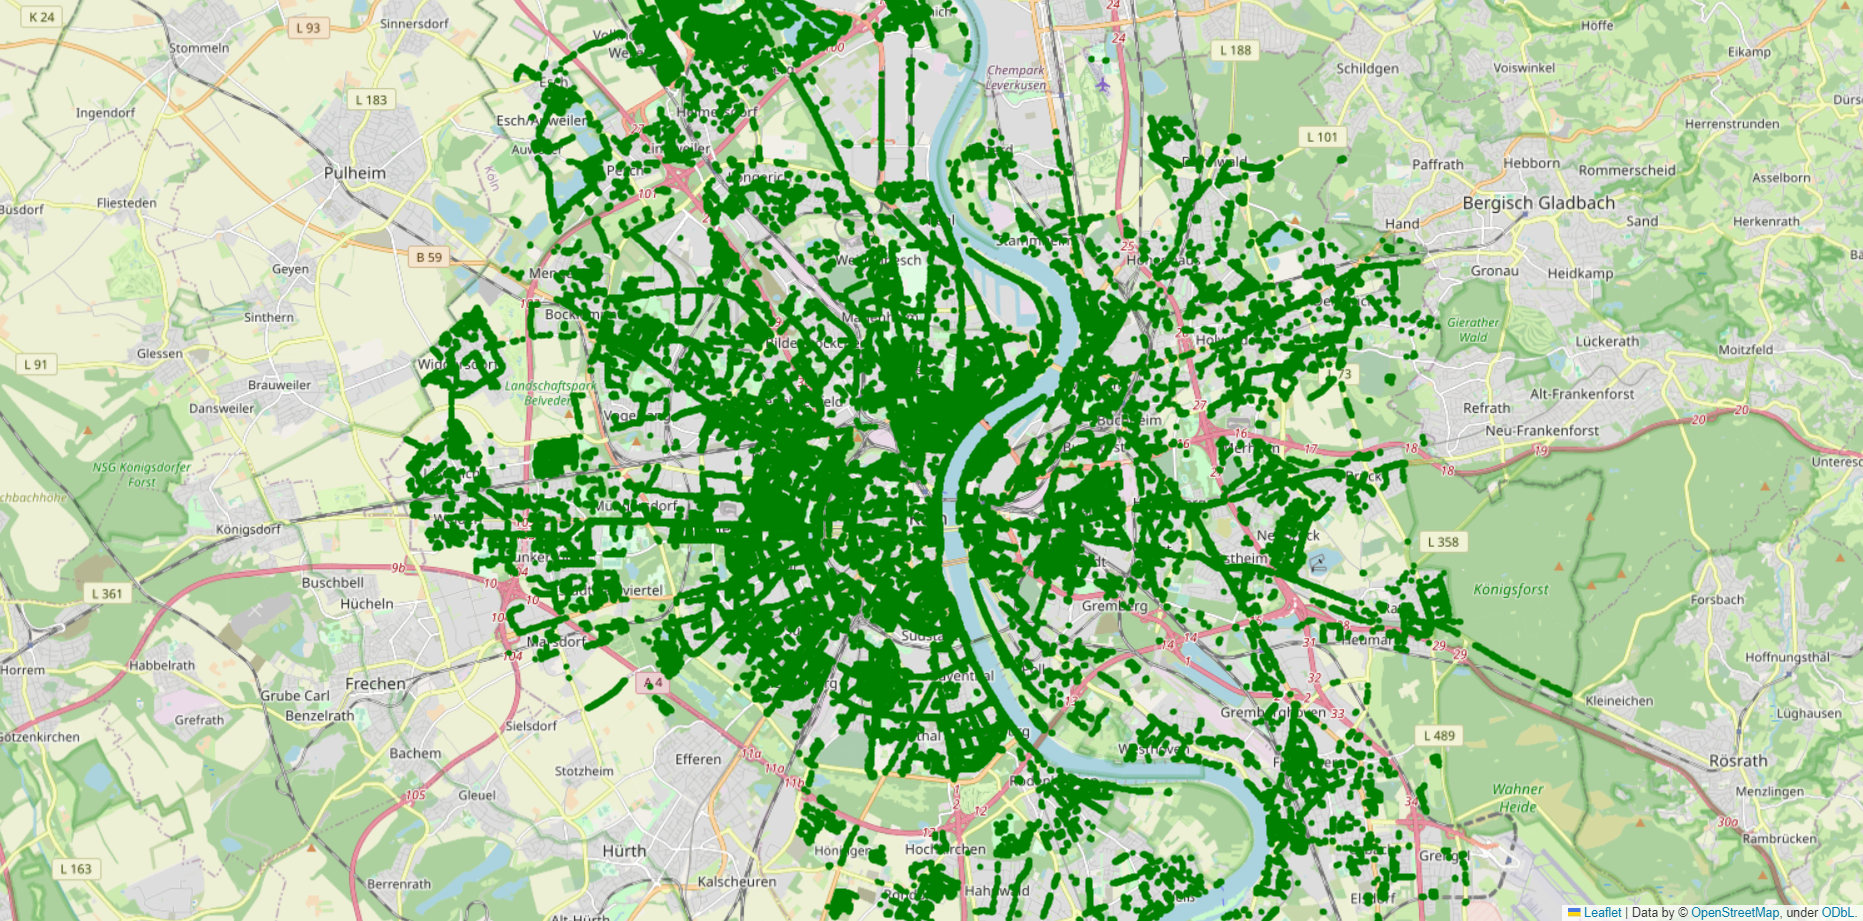

In [111]:
# Path to the saved image file
image_path = 'output_data/cologne_map.png'

num_of_trees_in_cologne = df3.shape[0]
display(HTML(f'<h2 style="color:black;">\n Visualization of Registered location of Trees in Cologne</h2>'))
# Display the image
display(Image(filename=image_path))
display(HTML(f'<h2 style="color:black;">\n Total number of Registered Trees in the region of Cologne are: {num_of_trees_in_cologne:.0f}</h2>'))

#### Geographical visualization of Registered Trees in the region of Cologne

In [112]:
# Coordinates in a projected coordinate system
y_coordinate = df4['longitude']
x_coordinate = df4['latitude']

# Create a Folium map centered around the mean
m = folium.Map(location=[x_coordinate.mean(), y_coordinate.mean()], zoom_start=10)

# Add the Stamen Terrain tile layer for land information
folium.TileLayer('OpenStreetmap').add_to(m)

# Add a circle marker for each coordinate
for index, row in df4.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=0.1,  # Set the radius of the circle marker
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7
    ).add_to(m)

# Define the bounding box
min_lat, max_lat = 50.06, 50.2
min_lon, max_lon = 8.5, 8.7

# Set the visible area of the map based on the bounding box
m.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])

# Save the map as an HTML file
# m.save('output_data/frankfurt_map_with_circles_selective_area.html')

# Save the map as an image
#m.save('output_data/frankfurt_map.png', 'PNG')

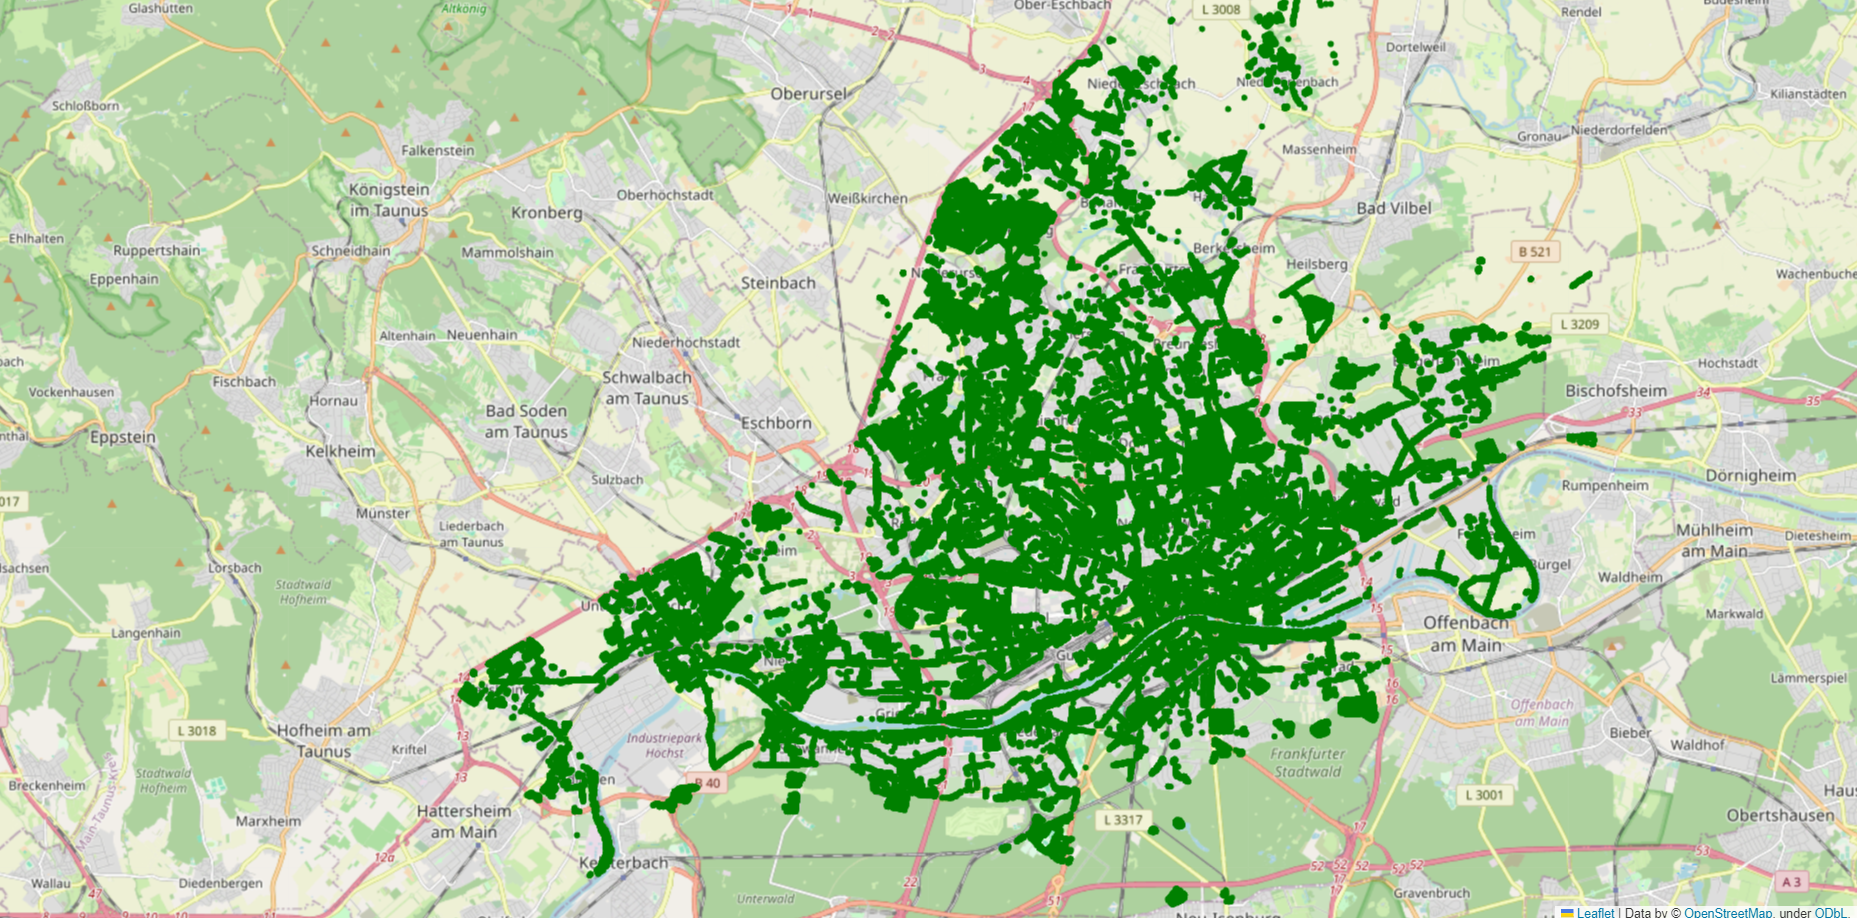

In [113]:
# Path to the saved image file
image_path = 'output_data/frankfurt_map.png'

num_of_trees_in_frankfurt = df4.shape[0]
display(HTML(f'<h2 style="color:black;">\n Visualization of Registered location of Trees in Frankfurt</h2>'))
# Display the image
display(Image(filename=image_path))
display(HTML(f'<h2 style="color:black;">\n Total number of Registered Trees in the region of Frankfurt are: {num_of_trees_in_frankfurt:.0f}</h2>'))

### Question 6. What the density of trees per square km in both the region?
To find out the desity of trees in the regions calculate the total number of trees and the area of the region

In [114]:
# Registered Number of trees in Colonge
num_of_trees_in_cologne = df3.shape[0]
area_of_cologne = 405.2 # in square kilometers

Tree_per_square_km_in_cologne = num_of_trees_in_cologne / area_of_cologne

In [115]:
# Registered Number of trees in Frankfurt
num_of_trees_in_frankfurt = df4.shape[0]
area_of_frankfurt = 248.3 # in square kilometers

Tree_per_square_km_in_frankfurt = num_of_trees_in_frankfurt / area_of_frankfurt

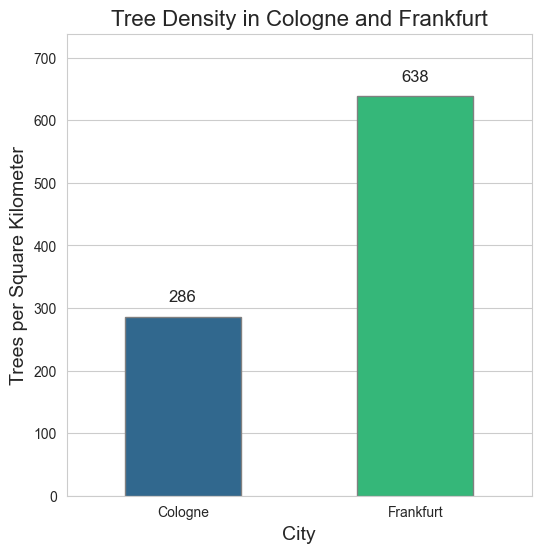

In [116]:
# Data
cities = ['Cologne', 'Frankfurt']
tree_density = [int(Tree_per_square_km_in_cologne), int(Tree_per_square_km_in_frankfurt)]  # Trees per square kilometer

# Create a bar chart using seaborn
plt.figure(figsize=(6, 6))
sns.barplot(x=cities, y=tree_density, palette='viridis', width = 0.5, saturation = 1, edgecolor='gray', linewidth=1)

# Adding annotations on top of the bars
for i, value in enumerate(tree_density):
    plt.text(i, value + 20, str(value), ha='center', va='bottom', fontsize=12)

# Adding title and labels
plt.title('Tree Density in Cologne and Frankfurt', fontsize=16)
plt.xlabel('City', fontsize=14)
plt.ylabel('Trees per Square Kilometer', fontsize=14)
# Increase the scale of the y-axis
plt.ylim(0, max(tree_density) + 100)

# Display the bar chart
plt.show()

### Insights
Frankfurt exhibits a higher tree density of 638 trees per square kilometer compared to Cologne's 287 trees per square kilometer. This indicates that Frankfurt has a more extensive urban green coverage, contributing to a visually lush and environmentally rich cityscape.

# Conclusion
In conclusion, the comprehensive analysis of tree demographics in Cologne and Frankfurt provides a nuanced understanding of the unique urban forestry landscapes in these cities. Cologne's diverse age spectrum and balanced height distribution underscore a well-rounded approach to environmental planning. Meanwhile, Frankfurt's exceptional outliers and varied trunk diameter distribution reflect a commitment to nurturing both thinner and thicker tree populations. The Pareto charts highlight the rich biodiversity in both cities, contributing to aesthetically pleasing and environmentally sustainable urban environments. Frankfurt's higher tree density further solidifies its position as a city with extensive green coverage, enhancing its visual allure and environmental richness. This comparative study reveals the distinctive yet complementary approaches each city takes toward fostering a vibrant and sustainable urban ecosystem.